Step 1: Import Necessary Dependencies

In [590]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.optim import lr_scheduler 
from torch.utils.data import Dataset, DataLoader

Step 2: Create Environment and Set Hyperparameters 

- Hyperparams: learning rate, number of epochs, loss function, batch 

In [591]:
#setting basic environment
torch.manual_seed(100)

#if we have a gpu then run network on that, if not use cpu which is much slower
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#" Varying learning rate between 0.0001 and 0.01 is considered optimal in most of the cases" - https://www.kdnuggets.com/2022/12/tuning-adam-optimizer-parameters-pytorch.html
lr = 0.001
batch_size = 1
num_epochs = 801
loss_fn = nn.L1Loss()

Step 3: Create Data

- Create a Dataframe that mimics our actual data in that there are 10 "PA Complexes," each of which has a numerical value for 20 different "Properties."

- Create a custom dataset for our dataframe, this will allow us to use Pytorch's DataLoader which helps us train

- Split data into test, train, val splits

- Input our data into the DataLoader

In [592]:
rng = np.random.default_rng(48598585)
data = {}
data.update({"KD Value": [rng.random()*10 for x in range(1,101)]})

for i in range(1, 21):
 data.update({"Property " + str(i): [rng.random()*100 for x in range(1,101)]})

df = pd.DataFrame(data , index = ["PA Complex " + str(x) for x in range(1,101)])

class CustomDataset(Dataset):
    def __init__(self, dataframe):
       self.dataframe = dataframe

    def __getitem__(self, index):
       row = self.dataframe.iloc[index].to_numpy()
       features = row[1:]
       label = row[0]
       return features, label

    def __len__(self):
       return len(self.dataframe)

train_set = df.iloc[0:51]
test_set = df.iloc[51:78]
val_set = df.iloc[78:101]
data1 = CustomDataset(dataframe=train_set)
data2 = CustomDataset(dataframe=test_set)
data3 = CustomDataset(dataframe=val_set)
train_loader = DataLoader(data1, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data2, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(data3, batch_size=batch_size, shuffle=True)

#UNCOMMENT to see what the sample data looks like
# print(test_set)
# for sample in train_loader:
#    print(sample)

Step 4: Create Our Model

- Create Model class

    - def _init__ is the function where we define our model, def forward is where we define our forward pass
    
    - Use ReLU to only pass positive values through the net, thus activating less neurons during each pass, thus allowing for easier computation. Use Leaky form to avoid dying ReLU problem (sometimes neurons may turn off permanently)
    
    - Dropout is used after each layer to reduce overfitting: co-adaptation occurs when multiple neurons extract the same
      or very similar features, thus emphasizing those features in the result. This can lead to over fitting if those
      features are specfic only to the training set. So, dropout randomly shuts down a # of neurons in a layer by
      setting their weights to 0. Frac of neurons zeroed out is **r_d**, all other neurons multiplied by **1/1-r_d** so overall sum of 
      neurons stays the same

- Instantiate the object

- Define the optimizer for use in training

In [593]:
class Simple_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(20, 50),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(50, 100),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(100, 200),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(200, 50),
            nn.LeakyReLU(),
            nn.Linear(50, 1),
        )

    def forward(self, x):
        output = self.model(x)
        return output
    
#to run using GPU, we have instantiate as usual but then send to GPU w/ .to() the device
simple_NN = Simple_NN().to(device=device)
optimizer_SNN = torch.optim.Adam(simple_NN.parameters(), lr=lr)

Step 5: Training Process
- We first create an accuracy function that returns the percentage accuracy, i.e. if the predicted kd is 3, and the true kd is 4, then predicted value is 75% of what we want

- Next define train function
    - We include 3 seperate blocks for each dataset. The model's weights are updated by training on the train set, and the model's hyperparameters are updated by checking the performance on the validation set for each epoch. We then exit the training loop (when we have gone through every epoch) and evaluate on the test set

    - We create 3 graphs, one for the training loss, one for the test loss on each PA Complex (in the test set), and one for the test accuracy on each PA Complex

    - We employ a number of functions and methods to train the model:
        - Adam Optimizer: Updates weights with optimizer.step()
        - Learning Rate Scheduler: decreases the learning rate every 100 epochs to avoid overshooting the minimum via scheduler.step()
        - L1 Loss = Mean Absolute Error Loss: Updated via loss.backward()
        - Use of model.train() and model.eval() b/c certain things like dropout layers funtion differently in Pytorch depending on if you want to train or evalulate

/Users/razorsharpe9/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 0/801, Train Loss: 2.8486, Train Accuracy: 2.34, Val Loss: 2.3159 Val Accuracy: 2.18
Epoch 20/801, Train Loss: 1.9549, Train Accuracy: 1.89, Val Loss: 3.0624 Val Accuracy: 1.29
Epoch 40/801, Train Loss: 1.5715, Train Accuracy: 1.65, Val Loss: 3.1531 Val Accuracy: 1.28
Epoch 60/801, Train Loss: 1.3883, Train Accuracy: 1.52, Val Loss: 3.2084 Val Accuracy: 1.26
Epoch 80/801, Train Loss: 1.2854, Train Accuracy: 1.44, Val Loss: 3.2472 Val Accuracy: 1.25
Epoch 100/801, Train Loss: 1.2243, Train Accuracy: 1.39, Val Loss: 3.2774 Val Accuracy: 1.24
Epoch 120/801, Train Loss: 1.1755, Train Accuracy: 1.36, Val Loss: 3.3016 Val Accuracy: 1.23
Epoch 140/801, Train Loss: 1.1409, Train Accuracy: 1.34, Val Loss: 3.3211 Val Accuracy: 1.23
Epoch 160/801, Train Loss: 1.1195, Train Accuracy: 1.32, Val Loss: 3.3369 Val Accuracy: 1.23
Epoch 180/801, Train Loss: 1.0992, Train Accuracy: 1.32, Val Loss: 3.3501 Val Accuracy: 1.23
Epoch 200/801, Train Loss: 1.0850, Train Accuracy: 1.30, Val Loss: 3.3612 Va

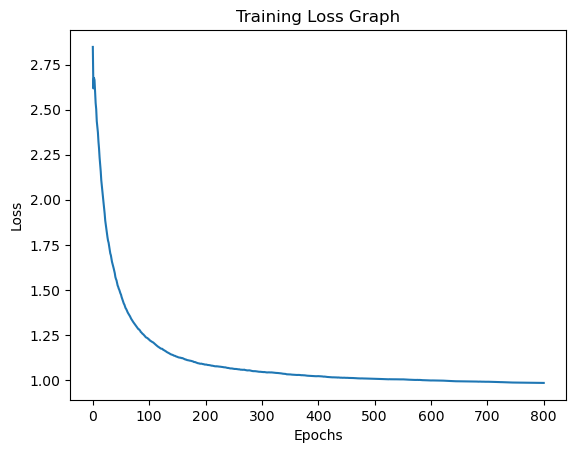

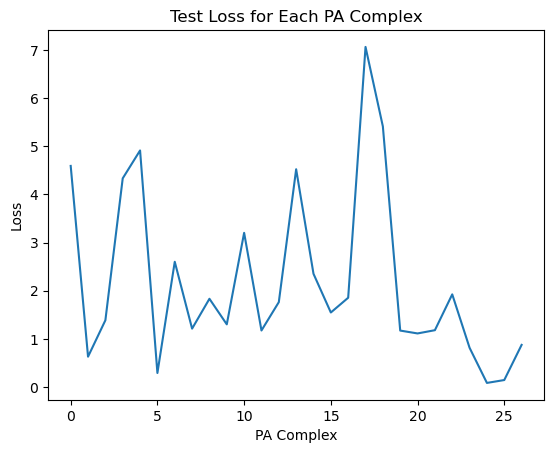

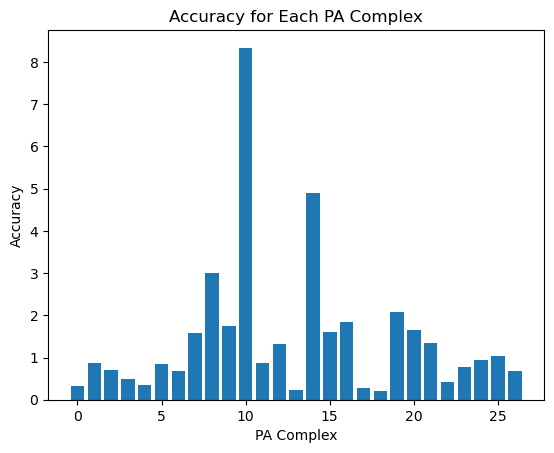

In [595]:
#UNCOMMENT to see untrained model predictions on train set
# for i, data in enumerate(test_loader):
#     values, labels = data
#     values = values.to(torch.float32)
#     untrained_preds = simple_NN(values)
#     print(untrained_preds)
#     print(labels)

def accuracy_fn(y_true, y_pred):
    return y_pred.item() / y_true.item()

def train(model, num_epochs, loss_fn, train_data, val_data, test_data, optimizer):
    epoch_loss1 = []
    epoch_loss2 = []
    train_acc = []
    val_acc = []
    test_acc =[]
    train_losses = []
    val_losses = []
    test_losses = []
    scheduler = lr_scheduler.StepLR(optimizer, step_size = 100, gamma=0.9)

    for epoch in range(num_epochs):
        
        model.train()
        for i, data in enumerate(train_data):
            values, label = data
            values = values.to(torch.float32)
            label = label.to(torch.float32)
            optimizer.zero_grad()
            train_preds = model(values)
            train_loss = loss_fn(train_preds, label)
            epoch_loss1.append(train_loss.item())
            train_acc.append(accuracy_fn(label, train_preds))
            train_loss.backward()
            optimizer.step()
            scheduler.step()
        train_losses.append(np.mean(epoch_loss1))
       
        model.eval()
        for j, data in enumerate(val_data):
            values, label = data
            values = values.to(torch.float32)
            label = label.to(torch.float32)
            val_preds = model(values)
            val_loss = loss_fn(val_preds, label)
            epoch_loss2.append(val_loss.item())
            val_acc.append(accuracy_fn(label, val_preds))
        val_losses.append(np.mean(epoch_loss2))

        if epoch % 20 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Train Loss: {np.mean(epoch_loss1):.4f}, Train Accuracy: {np.mean(train_acc):.2f}, Val Loss: {np.mean(val_losses):.4f} Val Accuracy: {np.mean(val_acc):.2f}")

    for k, data in enumerate(test_data):
        values, label = data
        values = values.to(torch.float32)
        label = label.to(torch.float32)
        test_preds = model(values)
        test_loss = loss_fn(test_preds, label)
        test_losses.append(test_loss.item())
        test_acc.append(accuracy_fn(label, test_preds))

    plt.plot(np.arange(num_epochs), train_losses)
    plt.title("Training Loss Graph")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()  

    plt.plot(np.arange(27), test_losses)
    plt.title("Test Loss for Each PA Complex")
    plt.xlabel("PA Complex")
    plt.ylabel("Loss")
    plt.show()

    plt.bar(np.arange(27), test_acc)
    plt.title("Accuracy for Each PA Complex")
    plt.xlabel("PA Complex")
    plt.ylabel("Accuracy")
    plt.show()

train(simple_NN, num_epochs, loss_fn, train_loader, val_loader, test_loader, optimizer_SNN)